# Wine Case Analysis: *Wine Spectator*'s Top 100 Wines, 1988-2020
List available online on *Wine Spectator*'s [Top 100 Lists web site](https://top100.winespectator.com/lists/).

## File Setup

In [28]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import bar_chart_race as bcr
import seaborn as sns

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other packages
from scipy import stats
from sklearn import linear_model

# import geo packages
import geopandas as gpd
import descartes
from shapely.geometry import Point, Polygon

# import Geopy packages
import geopy
from geopy.geocoders import Nominatim

In [29]:
# initialize vizualization set
sns.set(style="whitegrid", palette="colorblind", color_codes=True)
sns.mpl.rc("figure", figsize=(10, 6))

# Jupyter Notebook
%matplotlib inline

## Dataframe Exploration

In [30]:
# Note: save CSV files in UTF-8 format to preserve special characters.
df_Wine = pd.read_csv('./Wine_Hier01.csv')
df_GeoCache = pd.read_csv('./GeoCache.csv')
df_Flag = pd.read_csv('./emoji_list.csv')

In [31]:
df_Wine.shape

(3301, 25)

In [32]:
df_Wine.dtypes

Review_Year           float64
Rank                   object
Vintage                object
Score                 float64
Price                  object
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [33]:
# CSV of wines is retaining a blank row at the end of the dataset. Remove the last row to prevent data type errors.

# number of rows to drop
n = 1

df_Wine.drop(df_Wine.tail(n).index, inplace = True)

In [34]:
# Review_Year
# Convert Review_Year from float to int
df_Wine['Review_Year'] = df_Wine['Review_Year'].astype(int)

In [35]:
df_GeoCache.shape

(1224, 8)

In [36]:
df_Flag.shape

(19, 3)

In [37]:
df_Wine.sample(10)

,Review_Year,Rank,Vintage,Score,Price,Winemaker,Wine,Wine_Style,Grape_Blend,Blend_List,...,Best_Drink_from,Best_Drink_Through,Review,Hierarchy,Address,loc,point,lat,long,altitude
281,2018,82,2016,90.0,19,Pendulum,Cabernet Sauvignon Columbia Valley,Red,Cabernet Sauvignon,NaN,...,2018.0,2023.0,"Sleek and well-defined, with expressive black ...",Hierarchy_01,"Washington State, USA","Washington, United States","(47.2868352, -120.212613, 0.0)",47.286835,-120.212613,0.0
531,2015,32,2012,91.0,15,Viña Carmen,Cabernet Sauvignon Maipo Valley Alto Gran Reserva,Red,Cabernet Sauvignon,NaN,...,2015.0,2019.0,"A rich, well-spiced red, with luscious flavors...",Hierarchy_01,"Maipo Valley, Chile","Maipo, Buin, Provincia de Maipo, Región Metrop...","(-33.7328646, -70.7812358, 0.0)",-33.732865,-70.781236,0.0
1924,2001,25,1997,96.0,190,Gaja,Langhe Sperss,Red,Nebbiolo,NaN,...,2005.0,NaN,"A superb Sperss, with refined aromas of minera...",Hierarchy_01,"Piedmont | Piemonte, Italy","Piedmont Properties, 78, SP50, San Marzano Oli...","(44.7605629, 8.2998538, 0.0)",44.760563,8.299854,0.0
1807,2002,8,1997,96.0,62,Marchesi de' Frescobaldi,Brunello di Montalcino Castelgiocondo,Red,Brunello di Montalcino,NaN,...,2004.0,NaN,Superbly crafted. Pretty aromas of black cherr...,Hierarchy_01,"Tuscany, Italy","Toscana, Italia","(43.4586541, 11.1389204, 0.0)",43.458654,11.138920,0.0
880,2012,81,2007,93.0,48,Collosorbo,Brunello di Montalcino,Red,Brunello di Montalcino,NaN,...,2014.0,2028.0,"This rich red shows plenty of bass notes, in t...",Hierarchy_01,"Tuscany, Italy","Toscana, Italia","(43.4586541, 11.1389204, 0.0)",43.458654,11.138920,0.0
809,2012,10,2010,95.0,120,Achával-Ferrer,Malbec Mendoza Finca Bella Vista,Red,Malbec,NaN,...,2012.0,2020.0,"Dark and powerful, yet elegant, with a delicio...",Hierarchy_01,"Mendoza, Argentina","Mendoza, Argentina","(-34.787093049999996, -68.43818677312292, 0.0)",-34.787093,-68.438187,0.0
1104,2009,5,2006,96.0,54,Barone Ricasoli,Chianti Classico Castello di Brolio,Red,Chianti,NaN,...,2011.0,NaN,"Shows amazing aromas of blackberry, with hints...",Hierarchy_01,"Tuscany, Italy","Toscana, Italia","(43.4586541, 11.1389204, 0.0)",43.458654,11.138920,0.0
69,2020,70,2017,92.0,33,Suavia,Soave Classico Monte Carbonare,White,Garganega,NaN,...,2020.0,2027.0,"Svelte and finely knit, this vivid white is dr...",Hierarchy_01,"Veneto, Italy","Veneto, Italia","(45.6476663, 11.8665254, 0.0)",45.647666,11.866525,0.0
554,2015,55,2010,92.0,30,Arcanum,Toscana Il Fauno,Red,Blend,"Merlot, Cabernet Franc, Cabernet Sauvignon and...",...,2017.0,2026.0,"A round version, featuring rich cherry fruit m...",Hierarchy_01,"Tuscany, Italy","Toscana, Italia","(43.4586541, 11.1389204, 0.0)",43.458654,11.138920,0.0
1130,2009,31,2007,98.0,75,Domaine St.-Préfert,Châteauneuf-du-Pape Collection Charles Giraud,Red,Blend,Grenache and Mourvèdre,...,2011.0,2030.0,"Dark roasted Kenya AA coffee, braised fig, cha...",Hierarchy_01,"Rhône, France","Rhône, Circonscription départementale du Rhône...","(45.8802348, 4.564533629559522, 0.0)",45.880235,4.564534,0.0


## Vintage California Zinfandel Wines where Cases Made was Non-Zero

In [38]:
# replace 'NaN' results in chart with 0 to facilitate analysis
df_Wine.fillna(value = 0, inplace = True)

In [39]:
# drop the non-numeric price row from the dataset
df_Wine = df_Wine[df_Wine.Price != '$49 / 500ml']

In [40]:
# Convert data type of price to numeric
df_Wine['Price'] = pd.to_numeric(df_Wine.Price, downcast = 'float')

In [41]:
df_Wine.dtypes

Review_Year             int64
Rank                   object
Vintage                object
Score                 float64
Price                 float32
Winemaker              object
Wine                   object
Wine_Style             object
Grape_Blend            object
Blend_List             object
Geography              object
Cases_Made            float64
Cases_Imported        float64
Reviewer               object
Drink_now             float64
Best_Drink_from       float64
Best_Drink_Through    float64
Review                 object
Hierarchy              object
Address                object
loc                    object
point                  object
lat                   float64
long                  float64
altitude              float64
dtype: object

In [42]:
# Include only Argentine Malbecs

df_Wine_V = df_Wine[
    (df_Wine.Address.str.contains('Argentina') == True) &
    (df_Wine.Grape_Blend.str.contains('Malbec') == True)
]

df_Wine_V.shape

(50, 25)

In [43]:
# Count of Argentine Malbecs by Review Year
df_AMR_Count = pd.DataFrame({'Count' : df_Wine_V.groupby(['Address', 'Grape_Blend', 'Review_Year'])['Score'].count()}).reset_index()
df_AMR_Count['Year_Type'] = 'Review'
df_AMR_Count = df_AMR_Count.rename(columns={"Review_Year": "Year"})
df_AMR_Count.head()

,Address,Grape_Blend,Year,Count,Year_Type
0,"Cafayate , Calchaqui Valley, Argentina",Malbec,2008,1,Review
1,"Cafayate , Calchaqui Valley, Argentina",Malbec,2009,1,Review
2,"Cafayate , Calchaqui Valley, Argentina",Malbec,2010,1,Review
3,"Cafayate , Calchaqui Valley, Argentina",Malbec,2018,1,Review
4,"Mendoza, Argentina",Malbec,2001,1,Review


In [44]:
# Count of Argentine Malbecs by Review Year
df_AMV_Count = pd.DataFrame({'Count' : df_Wine_V.groupby(['Address', 'Grape_Blend', 'Vintage'])['Score'].count()}).reset_index()
df_AMV_Count['Year_Type'] = 'Vintage'
df_AMV_Count = df_AMV_Count.rename(columns={"Vintage": "Year"})
df_AMV_Count.head()

,Address,Grape_Blend,Year,Count,Year_Type
0,"Cafayate , Calchaqui Valley, Argentina",Malbec,2006,1,Vintage
1,"Cafayate , Calchaqui Valley, Argentina",Malbec,2007,1,Vintage
2,"Cafayate , Calchaqui Valley, Argentina",Malbec,2008,1,Vintage
3,"Cafayate , Calchaqui Valley, Argentina",Malbec,2017,1,Vintage
4,"Mendoza, Argentina",Malbec,1999,1,Vintage


In [45]:
frames = [df_AMR_Count, df_AMV_Count]
df_AM_Count = pd.concat(frames)
df_AM_Count['Year'] = df_AM_Count.Year.astype(str)

In [46]:
# Score by Review Year

In [47]:
# Score by Vintage Year

### Visualization

In [48]:
# set palette and dimensions
palette = sns.color_palette('colorblind')

In [59]:
# define a function to graph summary data

def summary_barplot(year_type):
    
    df = df_AM_Count[(df_AM_Count.Year_Type == year_type)]
    
    g = sns.barplot(
        data = df,
        x = 'Count',
        y = 'Year',
        orient = 'h',
        hue = 'Year_Type',
        ci = None
    )
    
    sns.mpl.rc("figure", figsize=(10, 15))
    
    plt.suptitle('Count of Argentine Malbec Scores in Wine Spectator Top 100 Lists by ' + year_type)
    plt.savefig('./images/calzin_barplot_countscores_byyear.png')

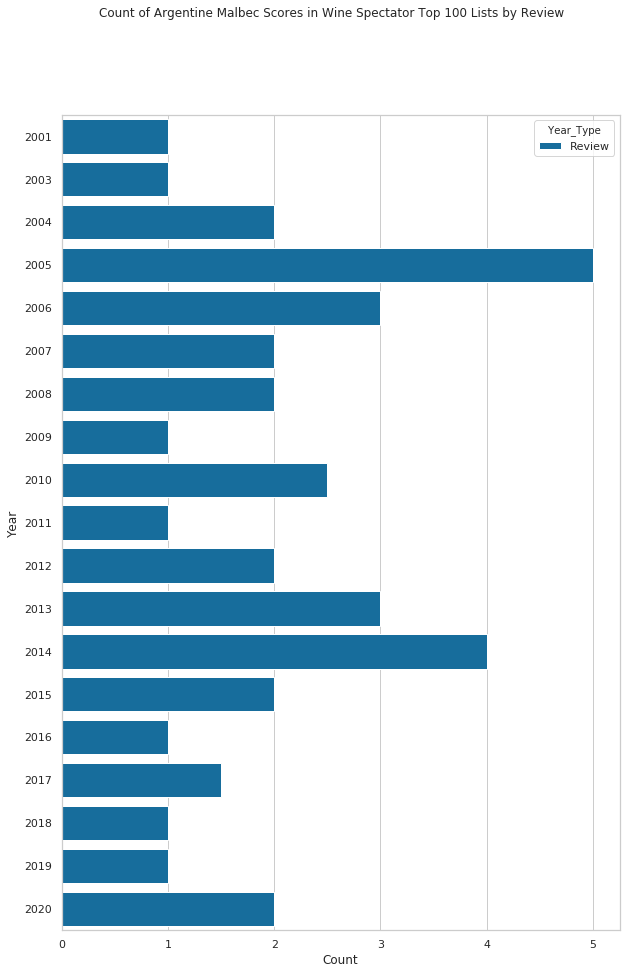

In [60]:
summary_barplot('Review')

### Analysis by Winemaker

In [61]:
# Count of California Zinfandels by Review Year by Winemaker
df_AMW_Count = pd.DataFrame({'Count' : df_Wine_V.groupby(['Winemaker'])['Score'].count()}).reset_index()

# Count of California Zinfandels by Review Year
df_AMW_Price = pd.DataFrame({'Average_Price' : df_Wine_V.groupby(['Winemaker'])['Price'].mean()}).reset_index()

# Count of California Zinfandels by Review Year
df_AMW_Score = pd.DataFrame({'Average_Score' : df_Wine_V.groupby(['Winemaker'])['Score'].mean()}).reset_index()

frame = [df_AMW_Count, df_AMW_Price, df_AMW_Score]
df_AMW = pd.concat(frame, sort = True, axis = 1)
df_AMW = df_AMW.T.drop_duplicates().T

df_AMW

,Winemaker,Count,Average_Price,Average_Score
0,Achával-Ferrer,6,96.5,94.8333
1,Alta Vista,1,19,91
2,Altocedro,1,30,92
3,Altos Las Hormigas,3,23.3333,91.6667
4,Altos de Medrano,1,24,91
5,Bodega Catena Zapata,6,33.8333,92.1667
6,Bodega Colomé,5,25,91.8
7,Bodega El Esteco,1,16,90
8,Bodega Luigi Bosca,2,27,91
9,Bodega Noemía de Patagonia,1,105,96


In [62]:
# define a function to graph summary data

def winemaker():
    
    df = df_AMW
    
    # Make the pairgrid
    g = sns.PairGrid(df.sort_values(by = 'Average_Score', ascending = False),
                     x_vars = df.columns[1:4],
                     y_vars = df.columns[0],
                     height = 10,
                     aspect = 0.25
                    )
    
    # Draw dot plot using stripplot function
    g.map(sns.stripplot,
          size = 10, 
          orient = 'h',
          jitter = False,
          palette = 'colorblind',
          linewidth = 1,
          edgecolor = 'w')
    
    # Use semantically meaningful titles for the columns
    titles = ['Count', 'Average Price', 'Average Score']
    
    for ax, title in zip(g.axes.flat, titles):
        
        # Set a different title for each axis
        
        ax.set(title = title)
        
        # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(False)

    sns.despine(left = True, bottom = True)
    
    plt.suptitle('Argentine Malbec\nCount, Average Score, and Average Price in Wine Spectator Top 100 Lists\nReview Years 1988-2020', y = 1.1)
    plt.savefig('./images/calzin_dotplot_countscores_byyear.png')

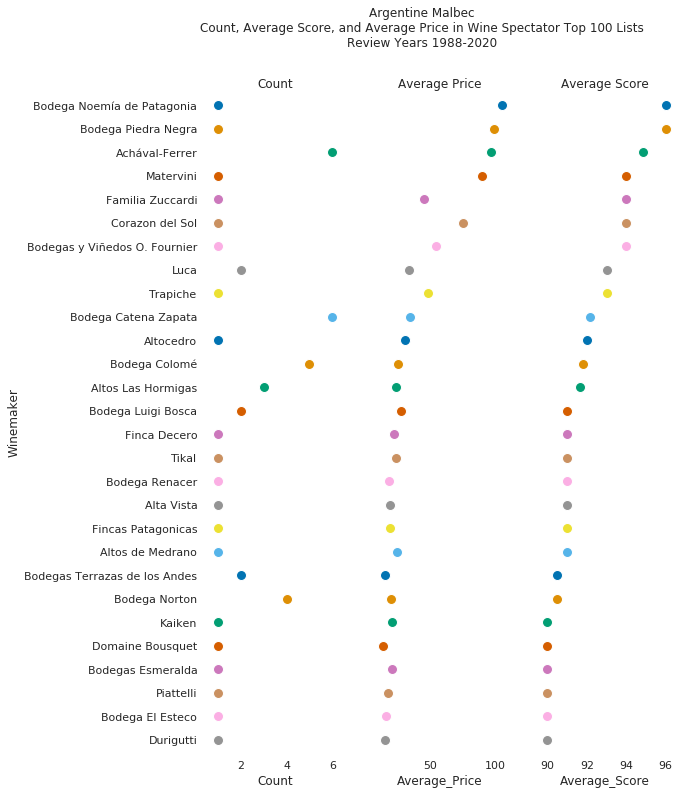

In [63]:
winemaker()